# Implement AdaBoost

# 1. read data

In [1]:
# import function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import time
import math
import random
%matplotlib inline

In [2]:
SampleData_SavePath = "./data/A1.csv"

SampleData_pd = pd.DataFrame()
if not os.path.isfile(SampleData_SavePath):
    print(SampleData_SavePath, "is not existed.")
else :
    print(SampleData_SavePath, "is existed.")
    SampleData_pd = pd.read_csv(SampleData_SavePath)

print(SampleData_pd)
print(SampleData_pd.dtypes)

# 不能将-1 和 1的值变为0和1的值。
# def preprocessLabel(label):
#     if label == -1 :
#         return 0
#     else:
#         return 1

# SampleData_pd['label'] = SampleData_pd.apply(lambda x :preprocessLabel(x['label']), axis = 1)
# print(SampleData_pd)

./data/A1.csv is existed.
   number    x    y  label
0       1   80  144      1
1       2   93  232      1
2       3  136  275     -1
3       4  147  131     -1
4       5  159   69      1
5       6  214   31      1
6       7  214  152     -1
7       8  257   83      1
8       9  307   62     -1
9      10  307  231     -1
number    int64
x         int64
y         int64
label     int64
dtype: object


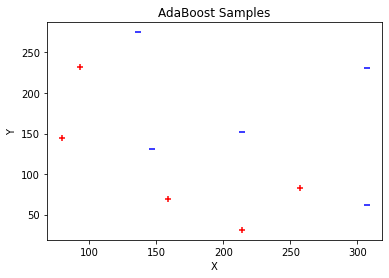

In [3]:
# display data
plt.title("AdaBoost Samples")
plt.xlabel('X')
plt.ylabel('Y')

for index, row in SampleData_pd.iterrows():
    if row['label'] == 1:
        plt.scatter(row['x'], row['y'], marker='+', color='red')
    else:
        plt.scatter(row['x'], row['y'], marker='_', color='blue')
plt.savefig("./pictures/samples.jpg")
plt.show()

In [4]:
# 先不要打乱，并将标签与数据分割出来。
# 分割的作用是方便与后面进行错误率的计算。这样混合在一起的数据集、单纯数据集、标签集都有了。
# Samples = SampleData_pd.sample(frac=1).copy()

Samples_data = SampleData_pd.iloc[:,:3].copy()
Labels_data = SampleData_pd.iloc[:,3].copy()

print(Samples_data)
print(Labels_data)
print(Labels_data.shape)

   number    x    y
0       1   80  144
1       2   93  232
2       3  136  275
3       4  147  131
4       5  159   69
5       6  214   31
6       7  214  152
7       8  257   83
8       9  307   62
9      10  307  231
0    1
1    1
2   -1
3   -1
4    1
5    1
6   -1
7    1
8   -1
9   -1
Name: label, dtype: int64
(10,)


# 2. complete train weak classifier

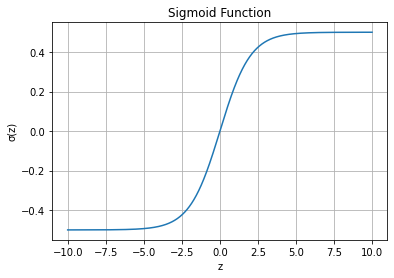

In [5]:
# common function
# activtion function 
def sigmoid(input):
    return (1.0/(1 + np.exp(-input)))-0.5

# display and survey/check/test sigmoid function
z = np.arange(-10, 10, 0.01)
fz = []
for zi in z:
    fz.append(sigmoid(zi))
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('σ(z)')
plt.plot(z, fz)
plt.grid()
plt.savefig("./pictures/sigmoid.jpg")
plt.show()

In [6]:
def displaySingleWeakClassifier(wc_type, samples, theta, error_rate, offset=10):
    plt.title("AdaBoost Weak Classifier")
    plt.xlabel('X')
    plt.ylabel('Y')

    for index, row in samples.iterrows():
        if row['label'] == 1:
            plt.scatter(row['x'], row['y'], marker='+', color='red')
        else:
            plt.scatter(row['x'], row['y'], marker='_', color='blue')
    if wc_type == 'x':
        plt.axvline(theta)
        y_mean = samples['y'].mean()
        plt.text(theta + offset/2, y_mean, 'error rate =%0.2f\n theta =%0.2f'%(error_rate, theta))
    else:
        plt.axhline(theta)
        x_mean = samples['x'].mean()
        # 加了一个偏移量，避免显示的字和线条重合在一起。
        plt.text(x_mean, theta + offset, 'error rate =%0.2f\n theta =%0.2f'%(error_rate, theta))
    plt.show()

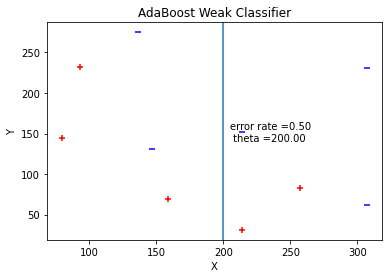

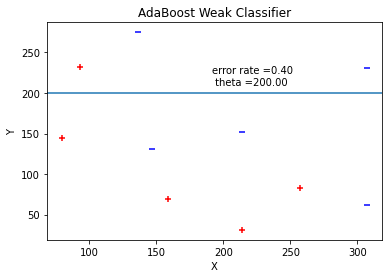

In [7]:
# 测试显示弱分类器的函数。
displaySingleWeakClassifier('x', SampleData_pd, 200, 0.5)

displaySingleWeakClassifier('y', SampleData_pd, 200, 0.4)

In [8]:
# 测试更新样本权重函数。
temp = Labels_data.copy()
temp[6] = 1
temp[2] = 1
temp[1] = -1
print(temp)
print(temp.shape[0])

def update_sample_weight(samples_weight_before, wc_weight, labels, prediction):
    # 更新样本的权重。
    new_samples_weight = []
    for i in range(len(labels)):
        new_samples_weight.append(samples_weight_before[i] * np.exp(-wc_weight * labels[i] * prediction[i]))
        pass
    # return np.array(new_samples_weight/sum(new_samples_weight)).reshape([len(labels) ,1])
    return new_samples_weight/sum(new_samples_weight)

samples_weight_before = [(1.0/(SampleData_pd.shape[0])) for i in range(Samples_data.shape[0])]
wc_weight = 0.8
print(update_sample_weight(samples_weight_before, wc_weight, Labels_data, temp))

# def compare(a, b):
#     if a == b:
#         return 1
#     else:
#         return 0

# def calculate_Error_rate(labels, pred, sample_weight):
#     # 计算弱分类器的错误率。
#     temp_pd = pd.concat([labels, pred], axis=1)
#     # temp_pd['ret'] = temp_pd.apply(lambda x : compare(temp_pd['label'], temp_pd['pred']), axis=1)
#     ret = 0
#     for i in range(labels.shape[0]):
#         if labels[i] != pred[i]:
#             ret += sample_weight[i]
#     return ret

0    1
1   -1
2    1
3   -1
4    1
5    1
6    1
7    1
8   -1
9   -1
Name: label, dtype: int64
10
[0.04574754 0.22658907 0.22658907 0.04574754 0.04574754 0.04574754
 0.22658907 0.04574754 0.04574754 0.04574754]


In [34]:
def WeakClassifier(input, theta):
    temp = sigmoid((input - theta))
    if temp >= 0:
        Predict_Label = -1
    else:
        Predict_Label = 1
    return Predict_Label

class FindSingleWeakClassifierClass:
    """[summary]
    最终是需要输出一个弱分类器的形式。所以中间对数据集都以list的形式来处理。
    Returns:
        [type]: [description]
    """
    # step_size, 
    def __init__(self, wc_function, samples, labels, step_number=0):
        """[summary]
        samples_weight, 
        wc_type, 
        Args:
            wc_function ([function pointer]): [define weak classifier function form.]
            samples ([pd.DataFrame]): [samples data]
            labels ([pd.DataFrame]): [labels data]
            step_size ([float]): [step size]
            step_number ([float]): [step number]
            wc_type ([int:0|1]): [weak classifier type. in this example, 
                                    it means x or y.]
        """
        self.wc_function = wc_function
        # 这里不对，直接按照x或者y的类型，来计算对比的方向。
        # self.samples = samples
        self.labels = labels.tolist()
        # self.wc_type = wc_type
        # self.samples_weight = samples_weight
        self.step_number = step_number
        
        # 首先把输入的samples dataframe存下来，然后再处理为list的形式。
        # 这个temp_samples只是缓存用的。真正在后面计算的是使用的self.samples。
        self.temp_samples = samples
        self.samples = []
        # self.selected_theta_list = selected_theta_list
        # , selected_theta_list

    def according_to_wctype_proecess_data(self, wc_type):
        # 并不需要将wc_type存储为self.wc_type，直接在每次对weakclassifier进行循环的时候输入一次即可。
        if wc_type == 'x':
            self.samples = self.temp_samples['x'].tolist()
            xMax = max(self.samples)
            xMin = min(self.samples)
            if self.step_number == 0:
                # calculate weakclassifier step if no step_number is inputted.
                self.step_number = self.temp_samples.shape[0]
            self.StepSize = (xMax - xMin) / self.step_number
        else:
            self.samples = self.temp_samples['y'].tolist()
            yMax = max(self.samples)
            yMin = min(self.samples)
            if self.step_number == 0:
                # calculate weakclassifier step if no step_number is inputted.
                self.step_number = self.temp_samples.shape[0]
            self.StepSize = (yMax - yMin) / self.step_number
        
    def predictSamples(self, theta):
        # prediction = pd.DataFrame(np.zeros((10,1)))
        # for index, row in self.samples.iterrows():
        #     self.wc_function(row, theta)
        prediction = [0 for i in range(len(self.samples))]
        for i in range(len(self.samples)):
            prediction[i] = self.wc_function(self.samples[i], theta)
        return prediction
    
    def choose_error_rate(self, selected_error_rate, error_rate_list):
        # 计算两个集合的差集，然后再从差集中选择出最小的值作为返回值。
        minvalue = min(list(set(error_rate_list).difference(set(selected_error_rate))))
        minIndex = error_rate_list.index(minvalue)
        if minvalue > 0.5:
            minvalue = min(error_rate_list)
            minIndex = error_rate_list.index(minvalue)
            return minvalue, minIndex
        else:
            return minvalue, minIndex

    def calculate_wc_weight(self, error_rate):
        wc_weight = 0.5 * math.log((1-error_rate)/error_rate)
        return wc_weight
    
    def calculate_Error_rate(self, labels, pred, sample_weight):
        # 计算弱分类器的错误率。
        ret = 0
        for i in range(len(labels)):
            if labels[i] != pred[i]:
                ret += sample_weight[i]
        return ret
    
    # def update_sample_weight(self, old_samples_weight, wc_weight, labels, prediction):
    #     # 更新样本的权重。
    #     new_samples_weight = []
    #     for i in range(len(labels)):
    #         new_samples_weight.append(old_samples_weight[i] * np.exp(-wc_weight * labels[i] * prediction[i]))
    #         pass
    #     return np.array(new_samples_weight/sum(new_samples_weight)).reshape([len(labels) ,1])
    
    def FindSingleWeakClassifier(self, new_samples_weight, wc_type, selected_error_rate_list=[]):
        location = -1
        temp_theta = []
        temp_error_rate = []
        temp_prediction = []
        temp_wc_weight = []
        # 初始时，样本的权重是平均值。
        # init_samples_weight = [(1.0/(self.samples.shape[0])) for i in range(self.samples.shape[0])]
        
        # 按照输入的弱分类器类型，生成指定的样本。
        self.according_to_wctype_proecess_data(wc_type)
        # print(new_samples_weight)
        for i in range(self.step_number):
            # 按照步长来训练弱分类器。
            theta = i * self.StepSize
            temp_theta.append(theta)
            temp_prediction = self.predictSamples(theta)
            
            single_error_rate = self.calculate_Error_rate(self.labels, temp_prediction, new_samples_weight)
            temp_error_rate.append(single_error_rate)
            temp_wc_weight.append(self.calculate_wc_weight(single_error_rate))
            
            # if single_error_rate >= 0.5:
            #     location = i
            #     break
        print("---1---")
        print(selected_error_rate_list)
        print(temp_error_rate)
        
        minValue, minIndex= self.choose_error_rate(selected_error_rate_list, temp_error_rate)
        # location = temp_error_rate.index(min(temp_error_rate))
        location = minIndex
        # print(location, minValue)
        print(location)
        print(temp_error_rate[location])
        print(temp_theta[location])
        print("---2---")
        return temp_theta[location], temp_error_rate[location], temp_prediction, temp_wc_weight[location]


---1---
[]
[0.5, 0.5, 0.5, 0.5, 0.4, 0.30000000000000004, 0.4, 0.5, 0.4, 0.4]
0.30000000000000004
113.5
---2---
theta = 113.5


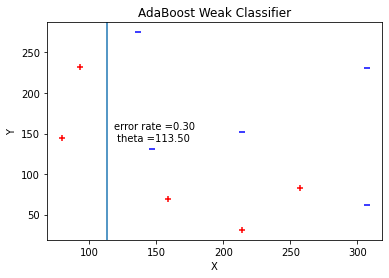

In [31]:
# 测试单个弱分类器的生成函数。
samples_weight = [(1.0/(Samples_data.shape[0])) for i in range(Samples_data.shape[0])]

getWCClass = FindSingleWeakClassifierClass(WeakClassifier, Samples_data, Labels_data)
theta, error_rate, predictionresult, wc_weight = getWCClass.FindSingleWeakClassifier(samples_weight, 'x')
print("theta = " + str(theta))
displaySingleWeakClassifier('x', SampleData_pd, theta, error_rate)

97.6


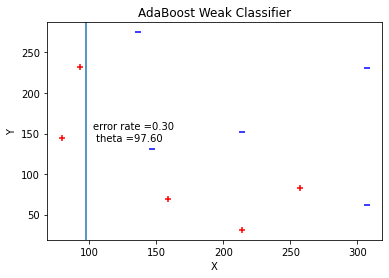

-----------1---------
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
-----------2---------
0.4236489301936017
-----------3---------
0    1
1    1
2   -1
3   -1
4    1
5    1
6   -1
7    1
8   -1
9   -1
Name: label, dtype: int64
-----------4---------
[1, -1, -1, 1, 1, 1, 1, 1, 1, -1]
-----------5---------
[0.06521739 0.15217391 0.06521739 0.15217391 0.06521739 0.06521739
 0.15217391 0.06521739 0.15217391 0.06521739]


In [11]:
# 测试找到的弱分类函数是否正确。
wc_weight_list = []

samples_weight = [(1.0/(Samples_data.shape[0])) for i in range(Samples_data.shape[0])]

getWCClass = FindSingleWeakClassifierClass(WeakClassifier, Samples_data, Labels_data)
theta, error_rate, predictionresult, wc_weight = getWCClass.FindSingleWeakClassifier(samples_weight, 'y')
print(theta)
displaySingleWeakClassifier('x', SampleData_pd, theta, error_rate)

print("-----------1---------")
print(samples_weight)
print("-----------2---------")
print(wc_weight)
print("-----------3---------")
print(Labels_data)
print("-----------4---------")
print(predictionresult)
print("-----------5---------")
new_samples_weight = update_sample_weight(samples_weight, wc_weight, Labels_data, predictionresult)
print(new_samples_weight)

In [12]:
# display multiple weak classifier
def displayMultipleWC(theta_list, wc_weight_list, wc_type_list, error_rate_list, samples, offset=10):
    i = 0
    plt.title("AdaBoost Multiple Weak Classifier")
    plt.xlabel('X')
    plt.ylabel('Y')

    for index, row in samples.iterrows():
        if row['label'] == 1:
            plt.scatter(row['x'], row['y'], marker='+', color='red')
        else:
            plt.scatter(row['x'], row['y'], marker='_', color='blue')
    for i in range(len(theta_list)):
        if wc_type_list[i] == 'x':
            plt.axvline(theta_list[i])
            y_mean = samples['y'].mean()
            plt.text(theta_list[i] + offset/2, y_mean, 
                     '[%d] error rate =%0.2f\n theta =%0.2f'%(i, error_rate_list[i], theta_list[i]))
        else:
            plt.axhline(theta_list[i])
            x_mean = samples['x'].mean()
            # 加了一个偏移量，避免显示的字和线条重合在一起。
            plt.text(x_mean, theta_list[i] + offset, 
                     '[%d] error rate =%0.2f\n theta =%0.2f'%(i, error_rate_list[i], theta_list[i]))
    
    output_info = "[weak classifier weight] = "
    i = 0
    for wc_weight in wc_weight_list:
        if i+1 == len(wc_weight_list):
            output_info += "(" + str(wc_weight) + ")"
        else:
            output_info += "(" + str(wc_weight) + ")" + " + "
        i += 1
    print(output_info)
    plt.show()

In [24]:
class FinalClassifierClass:
    def __init__(self, Samples_data, Labels_data, weak_classifier_count = 3):
        self.samples = Samples_data
        self.labels = Labels_data
        self.theta_list = []
        self.wc_weight_list = []
        self.wc_type_list = []
        self.error_rate_list = []
        self.weak_classifier_count = weak_classifier_count
        pass
    
    def final_classifier(self, x, y):
        realSum = 0
        classification = 0
        temp_hxMa = 0
        for i in range(self.weak_classifier_count):
            if self.wc_type_list[i] == 'x':
                temp_hxMa = self.wc_weight_list[i] * WeakClassifier(x, self.theta_list[i])
            else:
                temp_hxMa = self.wc_weight_list[i] * WeakClassifier(y, self.theta_list[i])
            realSum += temp_hxMa
        print("The classifier f(x) value is: " + str(realSum))
        classification = self.sgn(realSum)
        return classification

    def sgn(self, input):
        if input >= 0 :
            return 1
        else:
            return -1

    def train_fc(self):
        """[summary]
        the real return has three result. first is self.wc_type_list, second is self.theta_list, 
        third is self.wc_weight_list.  they are all used to final_classifier.
        """
        theta = 0
        error_rate = 0
        selected_error_rate_list = []
        init_samples_weight = [(1.0/(self.samples.shape[0])) for i in range(self.samples.shape[0])]
        getWCClass = FindSingleWeakClassifierClass(WeakClassifier, self.samples, self.labels)
        for i in range(self.weak_classifier_count):
            # 随机决定生成的弱分类器类型。
            if random.randint(0,1) == 0:
                classifierType = 'x'
            else:
                classifierType = 'y'
            
            self.wc_type_list.append(classifierType)
            if i == 0:
                theta, error_rate, predictionresult, wc_weight = \
                                        getWCClass.FindSingleWeakClassifier(init_samples_weight, 
                                                                                    classifierType)
                new_samples_weight = update_sample_weight(samples_weight, wc_weight, 
                                                          self.labels, predictionresult)
            else:
                theta, error_rate, predictionresult, wc_weight = \
                                        getWCClass.FindSingleWeakClassifier(new_samples_weight,
                                                                            classifierType, 
                                                                            selected_error_rate_list)
                new_samples_weight = update_sample_weight(samples_weight, wc_weight, 
                                                          self.labels, predictionresult)
            selected_error_rate_list.append(error_rate)
            self.theta_list.append(theta)
            self.wc_weight_list.append(wc_weight)
            self.error_rate_list.append(error_rate)
        # print(len(self.wc_type_list), len(self.theta_list), len(self.wc_weight_list))

In [35]:

weak_classifier_count = 3
FCC = FinalClassifierClass(Samples_data, Labels_data, weak_classifier_count)
FCC.train_fc()
sampleType = FCC.final_classifier(147, 131)
print("classifier type is :" + str(sampleType))

---1---
[]
[0.5, 0.5, 0.4, 0.4, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.4, 0.4, 0.4]
4
0.30000000000000004
97.6
---2---
---1---
[0.30000000000000004]
[0.4130434782608696, 0.4130434782608696, 0.3478260869565218, 0.4347826086956522, 0.3695652173913044, 0.3695652173913044, 0.4565217391304348, 0.6086956521739131, 0.6086956521739131, 0.6086956521739131]
2
0.3478260869565218
48.8
---2---
---1---
[0.30000000000000004, 0.3478260869565218]
[0.4351851851851852, 0.4351851851851852, 0.4351851851851852, 0.4351851851851852, 0.3611111111111111, 0.22222222222222227, 0.29629629629629634, 0.4351851851851852, 0.3611111111111111, 0.3611111111111111]
5
0.22222222222222227
113.5
---2---
The classifier f(x) value is: -1.3643347441524725
classifier type is :-1


[weak classifier weight] = (0.4236489301936017) + (0.314304329711187) + (0.6263814842476838)


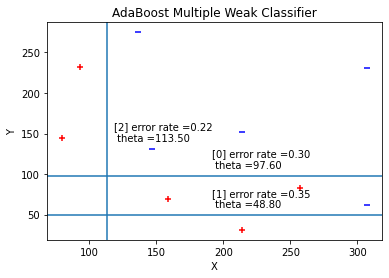

In [36]:
displayMultipleWC(FCC.theta_list, FCC.wc_weight_list, FCC.wc_type_list, FCC.error_rate_list, SampleData_pd)